# 공간 필터링
---


- 영상 처리 중에서 가장 기본적인 처리로써 인접 화소들의 값을 참조하여 화소의 값을 변경하는 처리이다. 

"공간 영역"라 하는 이유는?  \
이는 "주파수 영역"과 차이를 두기 위함이다.\
화소들이 존재하는 2차원 공간에서 필터링을 수행한다는 의미

공간 핕터링을 수식으로 나타내면 다음과 같다.\
$$ g(x,y) = T[f(x,y)] $$
여기서 f(x,y)는 입력 영상, g(x,y)는 출력 영상이고 T는 화소를 중심으로 이웃 화소들을 고려하여서 출력 화소의 값을 결정하는 연산자이다.



## 평균값 필터링 (blurring)
---

영상을 일부러 흐리게 하는 영상 처리.

영상에 잡음이 많은 경우 평균값 필터링을 통하여 잡음을 줄일 수 있다.

- 영상의 화소값을 인접 화소들의 평균값으로 교체한다. 평균값으로 교체하면 갑자기 튀는 값들을 부드럽게 할 수 있기 때문




In [9]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = [10, 5]

def imshow(tit, images):
    plt.title(tit)
    if len(images.shape)==3:
        plt.imshow(cv2.cvtColor(images, cv2.COLOR_BGR2RGB))
    else:
        plt.imshow(images, cmap='gray')
    plt.show()


(512, 512)
uint8


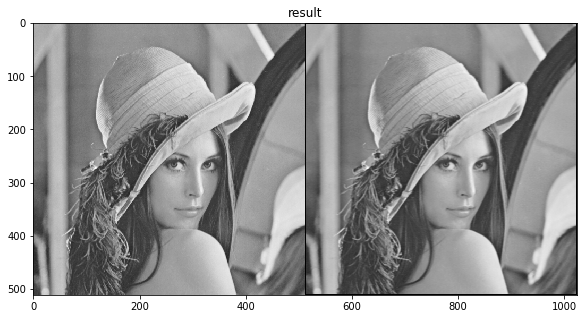

In [18]:
src = cv2.imread("../img/Lenna.png", 0)
dst = np.zeros(src.shape, dtype=np.uint8)
print(src.shape)
print(src.dtype)
for r in range(1, src.shape[0]-1):
    for c in range(1, src.shape[1]-1):
        sum = (int(src[r, c-1]) + int(src[r, c]) +int(src[r, c+1])) / 3
#         sum = (src[r, c-1] + src[r, c] + src[r, c+1]) / 3 # 오버플로우 발생
        dst[r,c] = np.uint8(sum)

result = np.hstack((src, dst))
imshow("result", result)

좌, 우 한 픽셀만 사용하여 평균값 필터링을 하였다.\
일종의 모션블러를 일으키는 것이다.

sum을 계산할 때 `sum = (src[r, c-1] + src[r, c] + src[r, c+1]) / 3`와 같이 계산하게 되면 오버플로우가 발생한다.

왜일까?


In [21]:
a = np.uint8(4)
b = np.uint8(200)
c = np.uint8(100)
d = np.uint8()
d = (a + b + c) / 4
print(d)

12.0


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in ubyte_scalars
  """


uint8의 범위를 넘어가게 계산하기 때문이다.

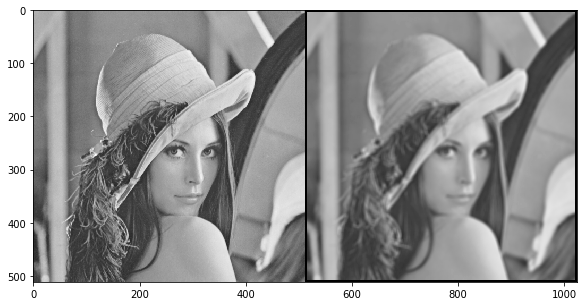

In [22]:
src = cv2.imread('../img/Lenna.png', 0)

dst = np.zeros(src.shape, dtype=np.uint8) # numpy는 기본적으로 float임

for r in range(3, src.shape[0] - 3):
    for c in range(3, src.shape[1] - 3):
        sum = 0
        for r1 in range(-3, 4): # 7X7마스크
            for c1 in range(-3, 4):
                sum += src[r + r1, c + c1]
        dst[r, c] = sum / 49

imshow("", np.hstack((src, dst)))

7 X 7 마스크를 사용하여 blurring을 했다. \
점점 많은 점을 참고하여 평균값을 구하므로 고주파 성분이 없어지는 것을 볼 수 있다.

또한 연산이 많기 때문에 point연산보다 속도가 훨씬 느리다.

이것을 모션블러 형태로 변경해보자

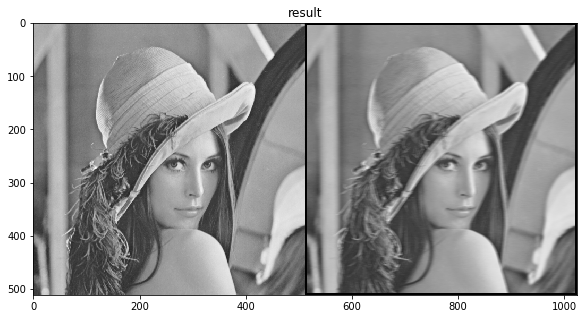

In [23]:
dst = np.zeros(src.shape, dtype=np.uint8)

for r in range(3, src.shape[0]-3):
    for c in range(3, src.shape[1]-3):
        sum = 0
        for c1 in range(-3, 4):
            sum += src[r,c+c1]
        dst[r, c] = sum/7

imshow("result", np.hstack((src, dst)))

뺄셈을 하게 되면 어떤 의미를 가질까?

오른쪽에 있는 픽셀을 빼게 되면 당연히 음수가 나올 수 있다.
그러면 범위가 -255~255로 변하게 되므로 문제가 생길 수 있다.

뺀다는 것은 difference를 알고 싶은 것임으로 **절대값**을 구해준다.




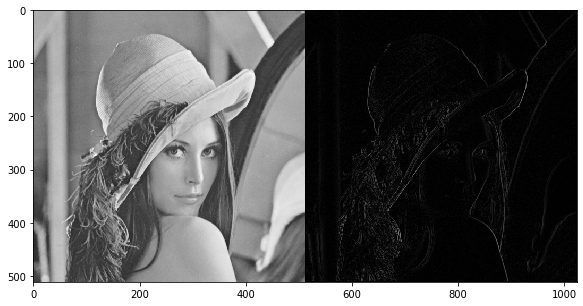

In [26]:
dst = np.zeros(src.shape, dtype=np.uint8)

for r in range(1, src.shape[0]-1):
    for c in range(1, src.shape[1]-1):
        out = np.abs(int(src[r,c]) - int(src[r, c+1]))
        dst[r,c] = out

# dst = (dst > 50) * 255
dst = dst.astype('uint8')
imshow("", np.hstack((src, dst)))


언뜻 보면 모든 외곽선이 나오는 것 같지만 그렇지 않다.

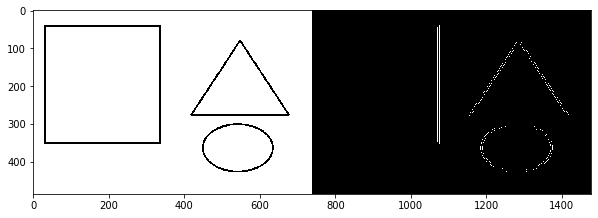

In [27]:
src = cv2.imread('../img/box.png', 0)
dst = np.zeros(src.shape, dtype=np.uint8)

for r in range(1, src.shape[0]-1):
    for c in range(1, src.shape[1]-1):
        out = np.abs(int(src[r,c]) - src[r, c+1])
        dst[r,c] = out
dst = (dst > 50) * 255
dst = dst.astype('uint8')
imshow("", np.hstack((src, dst)))

결과를 봤을 때 현재 픽셀에서 오른쪽픽셀을 ( 수평방향으로) 뺏을 경우\
수평선의 경계를 검출하지 못하는 것을 볼 수 있었다.

엣지연산을 통해서 대각선의 외형을 뽑아낼 수 있다.

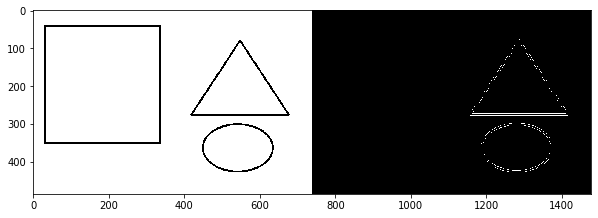

In [28]:
src = cv2.imread('../img/box.png', 0)
dst = np.zeros(src.shape, dtype=np.uint8)

for r in range(1, src.shape[0]-1):
    for c in range(1, src.shape[1]-1):
        out = np.abs(int(src[r,c]) - src[r+1, c])
        dst[r,c] = out
dst = (dst > 50) * 255
dst = dst.astype('uint8')
imshow("", np.hstack((src, dst)))

수직선분은 검출되지 않는다.

근데 왜 사각형은 안되지??

옆에 있는 것을 빼주면 모션 블러 효과?

# 컨벌루션 (convolution)
---

- 중심 화소의 값을 인접 화소값들의 가중 합으로 대체하는 연산

가중치는 2차원 배열로 주어지며 커널, 필터, 마스크라 불림\
크기는 3x3, 5x5, 7x7과 같이 홀수이다.

행렬을 만들어 `filter2D` 함수를 사용할 수 있다.


In [29]:
mask = np.array([[1/9.0, 1/9.0, 1/9.0],
                [1/9.0, 1/9.0, 1/9.0],
                [1/9.0, 1/9.0, 1/9.0]])
print(mask)

[[0.11111111 0.11111111 0.11111111]
 [0.11111111 0.11111111 0.11111111]
 [0.11111111 0.11111111 0.11111111]]


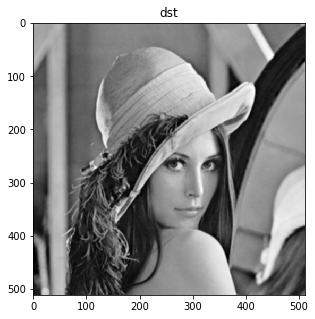

uint8


In [30]:
src = cv2.imread('../img/Lenna.png', 0)
dst = cv2.filter2D(src, -1, mask)
imshow('dst', dst)
print(dst.dtype)

기본적으로 padding이 되기 때문에 계산하지 못하는 쪽은\
`dst = cv2.convertScaleAbs(dst)`\
음수가 발생하지 않도록 절대값을 취해준다.

이전에 float로 변경하여 uint8로 음수값을 취하지 못하는 side effect를 방지한다.

In [31]:
mask = np.array([[0, 0, 0], 
                [0, 1, -1], 
                [0, 0, 0]])
print(mask)

[[ 0  0  0]
 [ 0  1 -1]
 [ 0  0  0]]


In [32]:
src = cv2.imread('../img/Lenna.png', 0)
src = src.astype('float')
print(src.dtype)

float64


In [33]:
dst = cv2.filter2D(src, -1, mask)
print(dst.dtype)

float64


In [34]:
print(dst)

[[  0.   1.   1. ...  13.  24. -24.]
 [  0.   1.   1. ...  13.  24. -24.]
 [  0.   1.   1. ...  13.  24. -24.]
 ...
 [  0.  -6.   0. ...   3.  -2.   2.]
 [  0. -11.   3. ...  -1.  -4.   4.]
 [  0. -11.   3. ...  -1.  -4.   4.]]


음수가 발생하는 것을 볼 수 있다.

In [35]:
dst = cv2.convertScaleAbs(dst)
print(dst)

[[ 0  1  1 ... 13 24 24]
 [ 0  1  1 ... 13 24 24]
 [ 0  1  1 ... 13 24 24]
 ...
 [ 0  6  0 ...  3  2  2]
 [ 0 11  3 ...  1  4  4]
 [ 0 11  3 ...  1  4  4]]


음수를 없애주는 것을 볼 수 있음

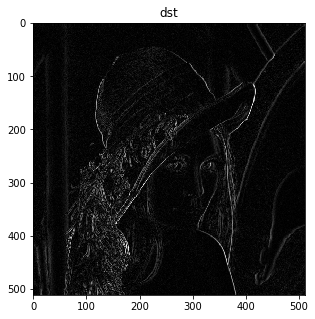

In [36]:
imshow("dst", dst)

## 평균값 필터링
---

open cv에서 지원하는 평균값 필터링 함수는 `blur()`이다.


(256, 256, 3)


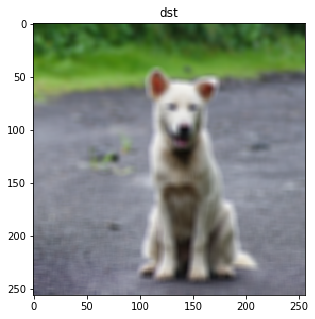

In [37]:
img = cv2.imread('../img/dog.bmp')
print(img.shape)

dst = cv2.blur(img, (7,7))
imshow('dst', dst)

## 가우시안 필터링
---

__가까이에 있는 것은 많이 반영하고 멀리있는 것은 가중치를 낮게하여 적게 반영하는 것__

- 거리에 따라 가중치를 다르게 계산한다.

즉 계산을 통해서 나올 수 있는 마스크이다.

블러링 필터와 동급이며, 계산 시간이 더 많이 걸린다.\
커널 크기도 더 커야하며 정확도 측면에서는 가우시안 필터링을 사용한다.

그래서 일반적으로 평균 필터링보다는 가우시안 필터링은 더 많이 사용한다.

커널의 크기도 조절할 수 있지만 표준편차를 조절한다.\
표준편차를 크게할 경우 주변의 값을 많이 참조하고 작게할 경우 적게 참조한다.

표준편차가 엄청 커지게된다면 평균 필터링과 비슷해지는 것이고, \
표준편차가 엄청 작아지면 거의 원본과 같게 될 것이다.

사용은 `cv2.GaussianBlur(src, (15, 15), sigma)`로 사용한다.

In [39]:
img = cv2.imread('../img/dog.bmp')
print(img.shape)

(256, 256, 3)


**블러**

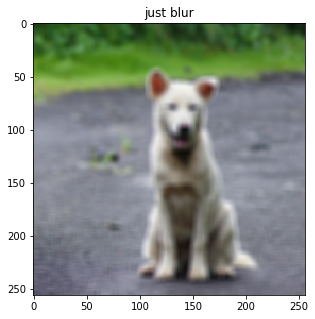

In [40]:
dst = cv2.blur(img, (7,7))
imshow('just blur', dst)

**Gaussian Blur**
표준편차 1.0

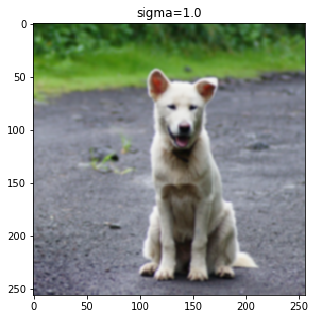

In [42]:
dst2 = cv2.GaussianBlur(img, (7,7), 1.0)
imshow("sigma=1.0", dst2)

**Gaussian Blur**
표준편차 2.0

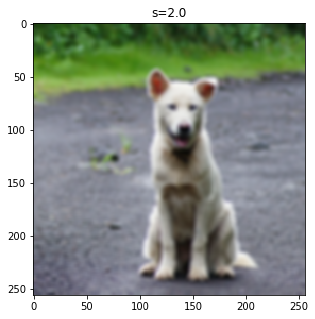

In [43]:
dst3 = cv2.GaussianBlur(img, (7,7), 2.0)
imshow('s=2.0', dst3)

**Gaussian Blur**
표준편차 10.0

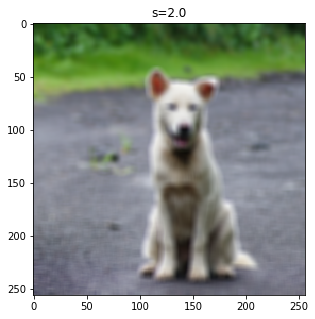

In [44]:
dst3 = cv2.GaussianBlur(img, (7,7), 10.0)
imshow('s=2.0', dst3)

동일 크기의 커널이라고 하더라도 분포에 따라서 차이를 볼 수 있다.

차이를 확실하게 볼 수 있는 rose사진으로 실습해보자

(320, 480)


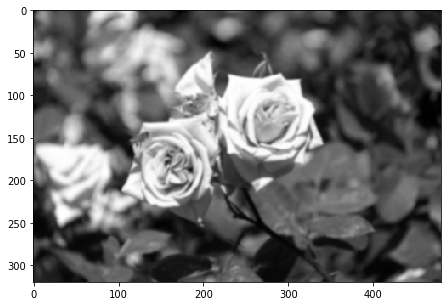

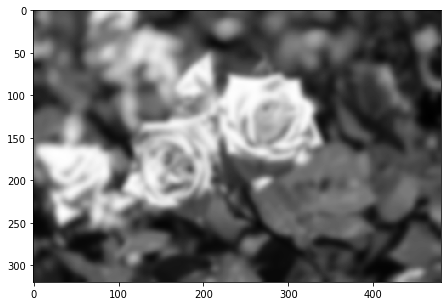

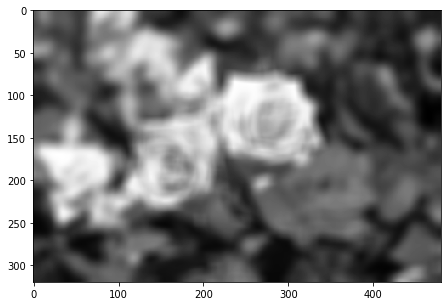

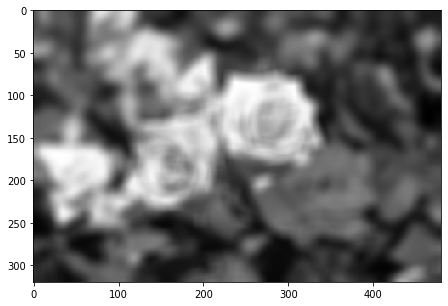

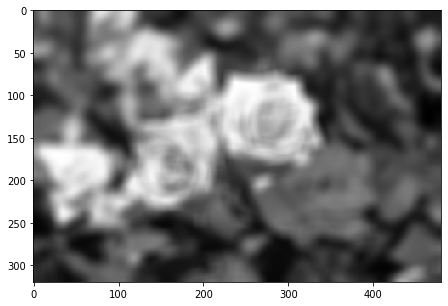

In [48]:
img = cv2.imread("../img/rose.bmp", 0)
print(img.shape)
sig = [1, 3, 20, 50, 90]
for s in sig:
    dst2 = cv2.GaussianBlur(img, (15, 15), s)
    imshow("", dst2)
#     cv2.imread("sigma=" + str(s), dst2)
#     cv2.waitKey()
# cv2.destroyAllWindows()

mask의 크기가 커지면 커질수록 연산 속돌가 느려지기 때문에 sigma의 크기를 높여서 조절하는 것이다.

## 엠보싱 효과
---
| -1 | -1 | 0 |
| ---|---|---|
|-1|0|1|
|0|1|1|

엠보싱 효과를 줄 수 있는 마스크

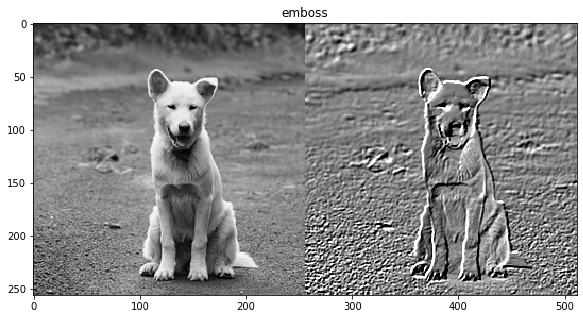

In [53]:
src = cv2.imread('../img/dog.bmp', 0)

emboss =  np.array([[-1, -1, 0],
                 [-1, 0, 1],
                 [0, 1,1]])

dst = cv2.filter2D(src, -1, emboss, delta=128)

imshow("emboss", np.hstack((src, dst)))

## 샤프닝
---

- 블러링의 반대
- 영상을 날카롭게 만드는 처리